<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/New_Attack_v31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
import scipy.stats as st
import tensorflow

from tqdm import tqdm
from functools import reduce
from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import os, time, math, csv, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture

import tensorflow
import numpy
import matplotlib.pyplot

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [2]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [3]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Pre-procesing

## Get working df

In [4]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  agg_df = aggreagator_v2(df)
  
  col_vals = remove_tail_main(df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

def cut_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.min([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.max([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

### Cutoff main

In [5]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  smoothed_data_frame = pd.DataFrame(savgol_filter(data_df, window_length = 5, polyorder = 2))
  
  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in data_df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = h_col
    cnt += 1
  smoothed_data_frame.rename(columns=rename_col, inplace=True)

  working_df = pd.merge(extra_info_df, smoothed_data_frame, left_index=True, right_index=True)
  return working_df
  
def main_cutoff(input_path):
  print('Reading data from file.')
  df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)
  df.iloc[0].fillna(method='bfill', inplace=True)
  df.iloc[1:df.shape[0]].fillna(method='pad', inplace=True)
  # Adding missing PBRS_id
  snippet = []
  val_cnt = 1
  idx = 0
  for sample in range(1, 101):
    for sample_id in range(0, 25):
      df.at[idx, 'PBRS_id'] = val_cnt
      idx +=1
      snippet.append(val_cnt)
    val_cnt += 1
  df['PBRS_id'] = df['PBRS_id'].astype(int)

  cut_point = cut_off_idx(df)
  working_df = select_working_data(df, cut_point)

  return working_df

In [6]:
#input_path = path + "/Spectrum/16QAM_v2/Copy of dataSet_gamma0_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x81km_primeStep.xlsx"
#orking_df = main_cutoff(input_path)
#display(working_df)

#working_df.to_csv(path+"/Spectrum/NN/new_data_working_df.csv", index=False)

## Get data

In [7]:
def frequencies_filter(df, num_selected_freq=20):
  info_df = df.iloc[:, [0]]
  data_df = df.iloc[:, 1:df.shape[1]]
  span_val = int(data_df.shape[1]/num_selected_freq)
  for i in range(num_selected_freq):
    df2 = data_df.iloc[:, (i+1)*span_val].to_frame()
    if i+1 == 1:
      new_df = df2
    else:
      new_df = pd.merge(new_df, df2, left_index=True, right_index=True)
  new_df = info_df.join(new_df)
  
  return new_df

In [8]:
def get_data(working_df, distances, num_features = 20):
  X=None
  Y=np.array([])
  dist_df = working_df.iloc[:, 3]
  freq_df = working_df.iloc[:, 6:working_df.shape[1]]
  samples_df = pd.merge(dist_df, freq_df, left_index=True, right_index=True)
  samples_df = samples_df.sort_values(by='Distance_km')
  if num_features != 'all':
    samples_df = frequencies_filter(samples_df, num_selected_freq = num_features)
  Y = samples_df.iloc[:, 0].to_numpy().astype('int').tolist()
  X = samples_df.iloc[:, 1:samples_df.shape[1]]
  
  return X, Y, samples_df

# Variational AutoEncoder Attack

In [52]:
data_df

,Distance_km,-40,-39.96875,-39.9375,-39.90625,-39.875,-39.84375,-39.8125,-39.78125,-39.75,...,39.7187499999999,39.7499999999999,39.7812499999999,39.8124999999999,39.8437499999999,39.8749999999999,39.9062499999999,39.9374999999999,39.9687499999999,39.9999999999999
320,80,-55.601873,-58.313393,-60.966793,-58.633765,-75.600638,-56.466683,-52.837122,-61.059200,-56.898920,...,-44.325321,-43.662388,-46.530123,-39.543908,-54.274755,-47.465094,-50.022882,-49.167601,-49.568444,-38.749969
1650,80,-54.374779,-64.645302,-65.577065,-55.518437,-60.547584,-56.981044,-55.099294,-53.982561,-59.385540,...,-51.949349,-40.818109,-52.693541,-52.309764,-41.432998,-38.420852,-42.032846,-41.910150,-40.125100,-40.249187
1000,80,-59.162484,-64.528626,-54.902552,-63.584416,-62.399307,-55.260007,-51.243984,-55.629637,-66.132300,...,-42.272974,-41.338932,-39.946798,-39.199972,-40.692786,-43.937138,-47.813259,-43.821331,-49.026646,-44.192960
1675,80,-54.584084,-62.765200,-57.522729,-50.547640,-68.547409,-58.979866,-71.381002,-52.439353,-56.864231,...,-54.094502,-45.648368,-56.220630,-45.415676,-63.919527,-40.552159,-46.605733,-52.352800,-51.555018,-38.391751
975,80,-63.298245,-67.109363,-63.163557,-49.133075,-54.447524,-57.501000,-66.923099,-51.888630,-54.358814,...,-53.893181,-40.390061,-59.194489,-54.083565,-63.316138,-38.181580,-42.709069,-52.882325,-40.473971,-38.469893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2000,-29.189577,-30.300210,-39.503294,-33.158181,-34.476166,-40.010566,-44.225301,-28.346133,-37.968280,...,-36.937687,-48.637887,-43.084647,-36.750605,-47.802465,-43.886657,-44.835075,-50.629993,-44.762399,-46.513822
1724,2000,-35.810020,-32.612656,-43.186892,-32.603325,-30.958379,-39.469135,-31.541364,-27.062608,-40.631134,...,-48.193530,-50.542609,-40.429080,-39.066619,-44.553675,-48.425986,-46.213295,-55.630297,-47.287142,-37.534762
1749,2000,-32.315696,-30.993539,-31.984248,-46.348456,-34.336087,-38.430535,-35.900627,-30.367432,-37.631087,...,-51.887629,-46.599178,-47.610897,-43.744549,-42.489766,-42.754451,-49.012908,-41.322331,-44.433203,-46.891872
2399,2000,-31.148561,-37.715292,-32.835155,-31.840061,-30.934384,-34.428963,-42.729755,-40.698608,-31.298114,...,-48.919877,-41.931219,-45.517435,-46.726714,-44.618948,-40.883129,-39.847173,-42.998323,-50.604531,-42.572338


## VAE Preprocessing

In [47]:
def vae_preprocess(working_df, distance_to_eval):
  distances = [x*80 for x in range(1, 26)]
  X, Y, data_df = get_data(working_df, distances, num_features = 'all')

  data_df = data_df.query('Distance_km == '+str(distance_to_eval))
  x_train, x_test, y_train, y_test = train_test_split(data_df.values[:, 1:data_df.shape[1]], data_df.values[:, 0:1], test_size=0.2, random_state=111)

  scaler = MinMaxScaler()
  data_scaler = scaler.fit(x_train)
  x_train = data_scaler.transform(x_train)
  x_test = data_scaler.transform(x_test)

  return data_df, x_train, x_test, data_scaler

In [40]:
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

In [48]:
data_df, x_train, x_test, data_scaler = vae_preprocess(working_df, '80')

In [50]:
# loss function vae
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = len(x_test)  
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict))
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [50]:
latent_space_dim = 2
distances = [x*80 for x in range(1, 26)]
epochs = 100
input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"
working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)

for d in distances:

  data_df, x_train, x_test, data_scaler = vae_preprocess(working_df, d)

  input_size = data_df.shape[1] - 1 # size of input encoder

  #--------------------------------------------------------Encoder--------------------------------------------------------
  x = tensorflow.keras.layers.Input(shape=(input_size,), name="encoder_input")

  encoder_dense_layer1 = tensorflow.keras.layers.Dense(units=512, name="encoder_dense_1")(x)
  encoder_activ_layer1 = tensorflow.keras.layers.ReLU(name="encoder_relu_1")(encoder_dense_layer1)

  encoder_dense_layer2 = tensorflow.keras.layers.Dense(units=256, name="encoder_dense_2")(encoder_activ_layer1)
  encoder_activ_layer2 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_2")(encoder_dense_layer2)

  encoder_dense_layer3 = tensorflow.keras.layers.Dense(units=128, name="encoder_dense_3")(encoder_activ_layer2)
  encoder_activ_layer3 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_3")(encoder_dense_layer3)

  encoder_dense_layer4 = tensorflow.keras.layers.Dense(units=64, name="encoder_dense_4")(encoder_activ_layer3)
  encoder_activ_layer4 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_4")(encoder_dense_layer4)

  encoder_dense_layer5 = tensorflow.keras.layers.Dense(units=32, name="encoder_dense_5")(encoder_activ_layer4)
  encoder_activ_layer5 = tensorflow.keras.layers.ReLU(name="encoder_activ_layer_5")(encoder_dense_layer5)

  shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
  encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

  encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
  encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

  encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

  def sampling(mu_log_variance):
      mu, log_variance = mu_log_variance
      epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
      random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
      return random_sample

  encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

  encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

  #--------------------------------------------------------Decoder--------------------------------------------------------
  decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
  decoder_dense_input_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_input_1")(decoder_input)
  decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_input_layer1)

  decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=64, name="decoder_dense_1")(decoder_reshape)
  decoder_activ_layer1 = tensorflow.keras.layers.ReLU(name="decoder_relu_1")(decoder_dense_layer1)

  decoder_dense_layer2 = tensorflow.keras.layers.Dense(units=128, name="decoder_dense_2")(decoder_activ_layer1)
  decoder_activ_layer2 = tensorflow.keras.layers.ReLU(name="decoder_relu_2")(decoder_dense_layer2)

  decoder_dense_layer3 = tensorflow.keras.layers.Dense(units=256, name="decoder_dense_3")(decoder_activ_layer2)
  decoder_activ_layer3 = tensorflow.keras.layers.ReLU(name="decoder_relu_3")(decoder_dense_layer3)

  decoder_dense_layer4 = tensorflow.keras.layers.Dense(units=512, name="decoder_dense_4")(decoder_activ_layer3)
  decoder_activ_layer4 = tensorflow.keras.layers.ReLU(name="decoder_relu_4")(decoder_dense_layer4)

  decoder_dense_layer5 = tensorflow.keras.layers.Dense(units=input_size, name="decoder_dense_5")(decoder_activ_layer4)
  decoder_output = tensorflow.keras.layers.ReLU(name="decoder_output")(decoder_dense_layer5)

  decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")

  #--------------------------------------------------------VAE--------------------------------------------------------
  vae_input = tensorflow.keras.layers.Input(shape=(input_size), name="VAE_input")
  vae_encoder_output = encoder(vae_input)
  vae_decoder_output = decoder(vae_encoder_output)
  vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
  vae.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=0.0001), loss=loss_func(encoder_mu, encoder_log_variance))

  #--------------------------------------------------------Train VAE--------------------------------------------------------
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
  history = vae.fit(x_train, None, epochs=epochs, batch_size=8, validation_split = 0.2, shuffle=True, callbacks=[early_stopping], verbose=0,) 
  
  # save autoencoder
  encoder.save(path+"/Spectrum/revised_VAE/model/VAE_encoder_epochs_"+str(epochs)+"_distance_"+str(d)+".h5") 
  decoder.save(path+"/Spectrum/revised_VAE/model/VAE_decoder_epochs_"+str(epochs)+"_distance_"+str(d)+".h5") 
  vae.save(path+"/Spectrum/revised_VAE/model/VAE_epochs_"+str(epochs)+"_distance_"+str(d)+".h5")

## test model

In [ ]:
epochs_num = 100

encoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_encoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)
decoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_decoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)

encoded_data = encoder.predict(x_test)
decoded_data = decoder.predict(encoded_data)

----------Decoded_Original------------
[1.376119  0.        0.        ... 1.3728728 0.        0.       ]
----------Decoded_Mod/10------------
[0.73102367 0.59341176 0.59341176 ... 0.73069905 0.59341176 0.59341176]
----------Inverted Decoded_Mod------------
[-54.77533146 -58.33876174 -58.1637022  ... -55.88650063 -58.65650506
 -60.17014862]
----------X_test------------
[0.1689451  0.2781684  0.48009138 ... 0.95236009 0.96324752 0.65855078]
----------Inverted X_test------------
[-69.47083024 -63.95298397 -60.23500229 ... -51.67834439 -53.09245393
 -58.49390386]


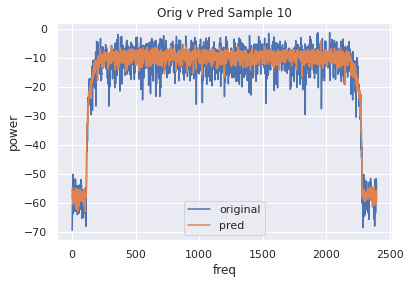

------------------------------------------------------


In [ ]:
inverted_decoded_data = scaler.inverse_transform(decoded_data)
inverted_x_test = scaler.inverse_transform(x_test)
decoded_result = []

# Adjusting data convertion and range
cnt = 0
for sample in decoded_data:
  sample_decoded = []
  delta_samples = []
  delta_cnt = 0
  for v in sample:
    sample_decoded.append((v/10))
    if delta_cnt <=50:
      delta_samples.append(round(((v/10) - x_test[cnt][delta_cnt]), 3))
    delta_cnt += 1
  delta_test_decoded = np.mean(delta_samples)
  if delta_test_decoded < 0:    
    new_sample_decoded = [x+abs(delta_test_decoded) for x in sample_decoded]
  elif delta_test_decoded > 0:
    new_sample_decoded = [x-abs(delta_test_decoded) for x in sample_decoded]
  else:
    new_sample_decoded = sample_decoded
  decoded_result.append(new_sample_decoded)
  cnt += 1

decoded_result = np.array(decoded_result)
inverted_decoded_results = scaler.inverse_transform(decoded_result)
check_plots_samples = [10]
for cps in check_plots_samples:
  print('----------Decoded_Original------------')
  print(decoded_data[cps])
  print('----------Decoded_Mod/10------------')
  print(decoded_result[cps])
  print('----------Inverted Decoded_Mod------------')
  print(inverted_decoded_results[cps])
  print('----------X_test------------')
  print(x_test[cps])
  print('----------Inverted X_test------------')
  print(inverted_x_test[cps])
  plt.plot(inverted_x_test[cps], label='original')  
  plt.plot(inverted_decoded_results[cps], label='pred')

  plt.title('Orig v Pred Sample {}'.format(cps))
  plt.ylabel('power')
  plt.xlabel('freq')
  plt.legend(loc='best')
  plt.show()
  print('------------------------------------------------------')

## Create final modification for synthetic data

In [ ]:
from scipy.signal import savgol_filter

# Combined test samples by mean of 0.9 CI data points er columns
combined_sample_x_test = []
for i in range(len(inverted_x_test[0])):
  col_val = []
  for sample in inverted_x_test:
    col_val.append(sample[i])
  ci_lower, ci_upper = st.t.interval(alpha=0.90, df=len(col_val)-1, loc=np.mean(col_val), scale=st.sem(col_val)) 
  col_val = np.array(col_val)
  col_val = col_val[ (col_val > ci_lower) & (col_val < ci_upper) ]
  
  combined_sample_x_test.append(np.mean(col_val))

# Combined decoded samples by mean of 0.9 CI data points er columns
combined_sample_decoded_results = []
for i in range(len(inverted_decoded_results[0])):
  col_val = []
  for sample_col in inverted_decoded_results:
    col_val.append(sample_col[i])
  ci_lower, ci_upper = st.t.interval(alpha=0.90, df=len(col_val)-1, loc=np.mean(col_val), scale=st.sem(col_val)) 
  col_val = np.array(col_val)
  col_val = col_val[ (col_val > ci_lower) & (col_val < ci_upper) ]    
  combined_sample_decoded_results.append(np.mean(col_val))

combined_sample_decoded_results = savgol_filter(combined_sample_decoded_results, 7, 3)

In [ ]:
print(combined_sample_decoded_results)

[-56.76101641 -59.22427959 -59.98573224 ... -57.91286958 -59.36579981
 -61.94829834]


[-59.764787128488, -59.926651610002246, -60.69784528812719, -60.539361819263036, -58.89255621791224, -57.96189579926683, -57.774972279788216, -59.668212142923366, -59.71106135808736, -59.46722298533744, -60.91408526312942, -60.55618035720494, -58.995463982075684, -58.916175350694246, -60.43561102403802, -59.08863538348017, -58.19729117872706, -57.921039323261546, -58.53827919456596, -59.46668809148053, -57.78689572398485, -57.92550278463549, -57.83749884925871, -59.173716865038855, -60.75644655913222, -60.83404694871823, -59.52032118951413, -60.46582988178384, -61.57063253034806, -58.17204800821927, -58.15405551591926, -59.35427437479895, -60.1412272935191, -59.6088445062083, -58.92813820434687, -60.21633672094457, -59.20590879625975, -60.001931367039084, -58.777706468474356, -57.893613198471364, -58.76577955833063, -59.822887709716895, -59.57360911223866, -58.558903109627224, -57.89366373121028, -59.188637120740424, -59.03713181827548, -59.2730931861961, -60.59320156960098, -59.939532

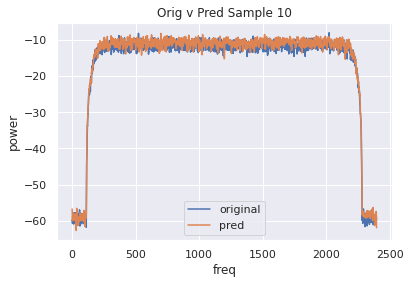

In [ ]:
print(combined_sample_x_test)
print(combined_sample_decoded_results)
plt.plot(combined_sample_x_test, label='original')
plt.plot(combined_sample_decoded_results, label='pred')

plt.title('Orig v Pred Sample {}'.format(cps))
plt.ylabel('power')
plt.xlabel('freq')
plt.legend(loc='best')
plt.show()

## Generate sample data

In [ ]:
def get_vae_moded_data(samples_filtered_df, encoder, decoder, num_sample_to_generate = 30, epochs_num = 100, distance_to_eval = 80, sensitivity=2):
  import random
  from scipy.signal import savgol_filter

  encoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_encoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)
  decoder = tensorflow.keras.models.load_model(path+"/Spectrum/attack_vae/autoencoder/VAE_decoder_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5", compile=False)

  samples_filtered_df = samples_filtered_df.query('Distance_km == '+str(distance_to_eval))
  samples_genrated = []

  col_headers = samples_filtered_df.columns.values.tolist()
  col_headers = col_headers[1:]

  for generate_sample_cnt in tqdm(range(0, num_sample_to_generate)):
    # Load dataset
    x_train, x_test, y_train, y_test = train_test_split(samples_filtered_df.values[:, 1:samples_filtered_df.values.shape[1]], samples_filtered_df.values[:, 0], test_size=0.2, random_state=111)

    scaler = MinMaxScaler()
    data_scaled = scaler.fit(x_train)

    max_scaled = scaler.data_max_
    min_scaled = scaler.data_min_

    x_train = data_scaled.transform(x_train)
    x_test = data_scaled.transform(x_test)

    # predit
    encoded_data = encoder.predict(x_test)
    decoded_data = decoder.predict(encoded_data)

    decoded_result = []
    # Adjusting data convertion and range
    cnt = 0
    for sample in decoded_data:
      sample_decoded = []
      delta_samples = []
      delta_cnt = 0
      for v in sample:
        sample_decoded.append((v/10))
        if delta_cnt <=50:
          delta_samples.append(round(((v/10) - x_test[cnt][delta_cnt]), 3))
        delta_cnt += 1
      delta_test_decoded = np.mean(delta_samples)
      if delta_test_decoded < 0:    
        new_sample_decoded = [x+abs(delta_test_decoded) for x in sample_decoded]
      elif delta_test_decoded > 0:
        new_sample_decoded = [x-abs(delta_test_decoded) for x in sample_decoded]
      else:
        new_sample_decoded = sample_decoded
      decoded_result.append(new_sample_decoded)
      cnt += 1

    decoded_result = np.array(decoded_result)
    inverted_decoded_results = scaler.inverse_transform(decoded_result)

    # Combined decoded samples by mean of 0.9 CI data points er columns
    combined_sample_decoded_results = []
    for i in range(len(inverted_decoded_results[0])):
      col_val = []
      for sample_col in inverted_decoded_results:
        col_val.append(sample_col[i])
      ci_lower, ci_upper = st.t.interval(alpha=0.90, df=len(col_val)-1, loc=np.mean(col_val), scale=st.sem(col_val)) 
      col_val = np.array(col_val)
      col_val = col_val[ (col_val > ci_lower) & (col_val < ci_upper) ]  
      mean_col = np.mean(col_val)
      std_col = np.std(col_val)
      final_col_val = mean_col + (std_col*random.uniform(-sensitivity, sensitivity)) # adding randomess to calc
        
      combined_sample_decoded_results.append(final_col_val)

    combined_sample_decoded_results = savgol_filter(combined_sample_decoded_results, 7, 3)

    samples_genrated.append(combined_sample_decoded_results)

  vae_samples_df = pd.DataFrame(samples_genrated, columns = col_headers)

  vae_samples_df.to_csv(path+"/Spectrum/attack_vae/syntectic_data/moded_data_"+str(distance_to_eval)+".csv", index=False)

  return vae_samples_df

In [ ]:
vae_samples_df = get_vae_moded_data(samples_filtered_df, encoder, decoder, num_sample_to_generate = 30, epochs_num = 100, distance_to_eval = 80, sensitivity=8)

100%|██████████| 30/30 [00:51<00:00,  1.73s/it]


# Abnormaly detector

## load data

In [35]:

input_path = path + "/Spectrum/NN/newest_revised_bootstraped_new_data_working_df-100_samples.csv"

working_df = pd.read_csv(input_path)
working_df['Distance_km'] = working_df['Distance_km'].astype(int)
working_df


,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-40,-39.96875,-39.9375,-39.90625,...,39.7187499999999,39.7499999999999,39.7812499999999,39.8124999999999,39.8437499999999,39.8749999999999,39.9062499999999,39.9374999999999,39.9687499999999,39.9999999999999
0,1,1,1,880,0,11,-36.136422,-34.465345,-33.802783,-32.742037,...,-47.004933,-40.619034,-50.304041,-44.009951,-37.192879,-36.508737,-46.127920,-43.322649,-45.968969,-45.596048
1,2,1,1,960,0,12,-32.977786,-34.051400,-32.132315,-31.098804,...,-50.480554,-50.624194,-45.929942,-40.857120,-50.799921,-40.415983,-41.450610,-41.787585,-45.373767,-37.430899
2,3,1,1,1040,0,13,-33.825672,-31.657262,-33.295539,-30.577181,...,-44.320837,-52.513250,-48.596095,-45.564403,-47.117885,-37.135902,-65.135437,-46.976909,-47.639177,-42.544868
3,4,1,1,1120,0,14,-35.324130,-31.486984,-35.010792,-31.710962,...,-38.856791,-45.682108,-47.422458,-40.724675,-43.665256,-41.115092,-42.172519,-45.863363,-46.768385,-46.248401
4,5,1,1,1200,0,15,-35.813901,-31.418297,-34.770859,-31.879652,...,-43.652922,-56.742188,-45.550116,-62.122239,-50.351370,-44.293278,-43.463769,-47.834434,-49.800060,-40.972806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2148,100,1,1680,0,21,-38.239925,-39.084139,-37.964249,-27.565670,...,-46.003004,-42.120410,-42.670983,-46.912779,-39.759438,-42.778495,-40.542199,-43.557983,-47.820081,-38.577168
2496,2236,100,1,1760,0,22,-29.821148,-34.911973,-42.170769,-28.534862,...,-43.429351,-45.622491,-44.043724,-44.336806,-51.890298,-38.048186,-39.000747,-41.529911,-38.598581,-48.672758
2497,2324,100,1,1840,0,23,-29.406863,-31.188593,-32.328514,-36.358456,...,-46.530153,-44.945883,-50.407649,-40.858874,-39.977030,-49.165666,-51.379580,-37.752134,-48.718136,-40.732077
2498,2412,100,1,1920,0,24,-29.160471,-34.246689,-38.672977,-27.461645,...,-43.016718,-42.743285,-48.029280,-52.255602,-49.089452,-37.704615,-47.854831,-52.445042,-43.961178,-48.577364


In [177]:
from tensorflow.keras.models import Model
class AutoEncoder_m(Model):
  def __init__(self):
    super(AutoEncoder_m, self).__init__()
    self.encoder = tf.keras.Sequential([
                                        tf.keras.layers.Dense(64, activation='relu'),
                                        tf.keras.layers.Dense(32, activation='relu'),
                                        tf.keras.layers.Dense(16, activation='relu'),
                                        tf.keras.layers.Dense(8, activation='relu')])
    
    self.decoder = tf.keras.Sequential([
                                    tf.keras.layers.Dense(16, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(2561, activation='sigmoid')])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [212]:
sen_arr = [1, 1.5, 2, 2.5, 3, 3.5]
for sensitivity in sen_arr:
  print('----------------------------------------Evaluating sensitivity of: '+str(sensitivity)+' ----------------------------------------')
  distances = [x*80 for x in range(1, 26)]
  epochs_num = 500

  res_AE = {'Orig_Distance':distances, 80: [], 160: [], 240: [], 320: [], 400: [], 480: [], 560: [], 640: [], 720: [], 800: [], 880: [], 960: [], 1040: [], 1120: [], 1200: [], 1280: [], 1360: [], 1440: [], 1520: [], 1600: [], 1680: [], 1760: [], 1840: [], 1920: [],  2000: []}
  for idx, d in enumerate(distances):
    print('Evaluating distance: '+str(d))
    X, Y, data_df = get_data(working_df, distances, num_features = 'all')
    #data_df['type_of_data'] = np.where(data_df['Distance_km'] == distance_to_eval, 1, 0) # distance == target val then val is 1
    #first_column = data_df.pop('type_of_data')
    #data_df.insert(0, 'type_of_data', first_column)
    #data_df.drop('Distance_km', axis=1, inplace=True)

    x_train, x_test, y_train, y_test = train_test_split(data_df.values, data_df.values[:, 0:1], test_size=0.2, random_state=111)

    scaler = MinMaxScaler()
    data_scaler = scaler.fit(x_train)
    x_train = data_scaler.transform(x_train)
    x_test = data_scaler.transform(x_test)

    train_data_df = pd.DataFrame(x_train)
    dist_sorted_norm = np.sort(train_data_df[0].unique(), axis=0)
    dist_to_eval = dist_sorted_norm[idx]

    # separate into normal and anormal data
    normal_train_data = pd.DataFrame(x_train).add_prefix('c').query('c0 == '+str(dist_to_eval)).values[:, 1:]
    normal_test_data = pd.DataFrame(x_test).add_prefix('c').query('c0 == '+str(dist_to_eval)).values[:, 1:]

    autoencoder_m = AutoEncoder_m()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
    autoencoder_m.compile(optimizer='adam', loss='mae')

    #train model
    history = autoencoder_m.fit(normal_train_data, normal_train_data, epochs=epochs_num, batch_size=8, validation_data=(x_train[:,1:],x_train[:,1:]), shuffle=True, callbacks=[early_stopping], verbose=0)
    # save model weigths
    autoencoder_m.save_weights(path+"/Spectrum/defense_autoencoder/autoencoder/AE_epochs_"+str(epochs_num)+"_distance_"+str(distance_to_eval)+".h5")  


    for attack_idx, attack_d in enumerate(distances):
      dist_to_attack = dist_sorted_norm[attack_idx]

      anormal_train_data = pd.DataFrame(x_train).add_prefix('c').query('c0 == '+str(dist_to_attack)).values[:, 1:]
      anormal_test_data = pd.DataFrame(x_test).add_prefix('c').query('c0 == '+str(dist_to_attack)).values[:, 1:]


      # reconstruction loss low
      encoder_out = autoencoder_m.encoder(normal_test_data).numpy()
      decoder_out = autoencoder_m.decoder(encoder_out).numpy()
      reconstructions = autoencoder_m.predict(normal_test_data)
      train_loss = tf.keras.losses.mae(reconstructions, normal_test_data) # get loss between normal data and reconstructed data
      
      #reconstruction loss high------------------attack-------------------------------------------------
      encoder_out_a = autoencoder_m.encoder(anormal_test_data).numpy()
      decoder_out_a = autoencoder_m.decoder(encoder_out_a).numpy()
      reconstructions_a = autoencoder_m.predict(anormal_test_data)
      train_loss_a = tf.keras.losses.mae(reconstructions_a, anormal_test_data)

      threshold_upper = np.mean(train_loss) + sensitivity*np.std(train_loss)
      threshold_lower = np.mean(train_loss) - sensitivity*np.std(train_loss)

      # values in between thresholds for -----------------------------------------------------------------------------------------------------------Normal data
      preds_upper = tf.math.less(train_loss, threshold_upper) # return True to values less than threshold return false for values bigger
      preds_lower = tf.math.greater(train_loss, threshold_lower)
      preds = tf.logical_and(preds_upper, preds_lower)

      tp = tf.math.count_nonzero(preds) # number of normal values classify correctly
      tp = tensorflow.keras.backend.get_value(tp)
      total_normal_data = preds.shape[0] # total amount of normal values
      fn = total_normal_data - tp

      # values outside threshold --------------------------------------------------------------------------------------------------------------------Anormal data Attack
      preds_a_upper = tf.math.greater(train_loss_a, threshold_upper) # return True to values greater than threshold return false for values smaller
      preds_a_lower = tf.math.less(train_loss_a, threshold_lower)
      preds_a = tf.logical_or( preds_a_upper, preds_a_lower)

      total_anormal_data = preds_a.shape[0] # total of anormal values
      tn = tf.math.count_nonzero(preds_a) # number of normal values classify correctly
      tn = tensorflow.keras.backend.get_value(tn)
      tn_old = tn
      fp = total_anormal_data - tn


      if d == attack_d: # it attack should be classify as norm because is the same distance
        tn = fp
        fp = tn_old
     
      precision = tp/(tp+fp)
      recall = tp/(tp+fn)
      f1_score = round(2*((precision * recall)/(precision + recall)), 2)

      res_AE[attack_d].append(f1_score)

    print('--------------------------------------------------------------------------')

  res_AE_df = pd.DataFrame.from_dict(res_AE)
  res_AE_df.to_csv(path+"/Spectrum/NN/AE_results/AE_f1_score_sensitibity_"+str(sensitivity)+".csv", index=False)


----------------------------------------Evaluating sensitivity of: 1 ----------------------------------------
Evaluating distance: 80
--------------------------------------------------------------------------
Evaluating distance: 160
--------------------------------------------------------------------------
Evaluating distance: 240
--------------------------------------------------------------------------
Evaluating distance: 320
--------------------------------------------------------------------------
Evaluating distance: 400
--------------------------------------------------------------------------
Evaluating distance: 480
--------------------------------------------------------------------------
Evaluating distance: 560
--------------------------------------------------------------------------
Evaluating distance: 640
--------------------------------------------------------------------------
Evaluating distance: 720
------------------------------------------------------------------

In [33]:
sen_arr = [1, 1.5, 2, 2.5, 3, 3.5]

avg_vals = {}
res = {}
same_dist_res = {}
same_dist_avg_res = {}

for s in sen_arr:
  f1_score_df = pd.read_csv(path+"/Spectrum/NN/AE_results/AE_f1_score_sensitibity_"+str(s)+".csv")
  t_distance = []

  for v_cnt in range(0, 25):
    v = f1_score_df.iloc[v_cnt, v_cnt+1]
    t_distance.append(v)

  same_dist_res[s] = t_distance
  same_dist_avg_res[s] = round(np.mean(t_distance), 2)

  mean_of_all_df = f1_score_df.mean().to_numpy()
  mean_of_all_df = mean_of_all_df[1:]
  res[s] = mean_of_all_df

  avg_res = round(np.mean(mean_of_all_df), 2)
  avg_vals[s] = avg_res

In [36]:
print(same_dist_res)

{1: [0.72, 0.7, 0.69, 0.78, 0.78, 0.71, 0.74, 0.64, 0.59, 0.68, 0.6, 0.68, 0.82, 0.75, 0.61, 0.87, 0.75, 0.65, 0.67, 0.63, 0.6, 0.65, 0.65, 0.7, 0.69], 1.5: [0.83, 0.8, 0.85, 0.89, 0.78, 0.9, 0.89, 0.88, 0.82, 0.84, 0.85, 0.84, 0.88, 0.88, 0.83, 0.93, 0.79, 0.95, 0.93, 0.84, 0.9, 0.88, 0.88, 0.83, 0.88], 2: [0.89, 0.95, 0.96, 0.94, 0.94, 1.0, 0.95, 0.96, 1.0, 0.95, 1.0, 0.92, 0.88, 1.0, 0.94, 0.93, 0.96, 0.95, 1.0, 0.95, 0.95, 1.0, 0.96, 0.96, 1.0], 2.5: [1.0, 0.95, 1.0, 0.94, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 3: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.96, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 3.5: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}


In [37]:
print(same_dist_avg_res)

{1: 0.69, 1.5: 0.86, 2: 0.96, 2.5: 0.99, 3: 1.0, 3.5: 1.0}


In [38]:
print(avg_vals)

{1: 0.6, 1.5: 0.65, 2: 0.68, 2.5: 0.68, 3: 0.68, 3.5: 0.68}


In [39]:
print(res)

{1: array([0.6992, 0.6164, 0.5544, 0.6332, 0.5944, 0.6204, 0.6076, 0.5484,
       0.6168, 0.624 , 0.6112, 0.5408, 0.5972, 0.564 , 0.62  , 0.6248,
       0.5708, 0.5924, 0.6564, 0.61  , 0.6152, 0.6224, 0.5524, 0.5604,
       0.632 ]), 1.5: array([0.7512, 0.66  , 0.5932, 0.6724, 0.6544, 0.6488, 0.6536, 0.5912,
       0.6672, 0.67  , 0.6456, 0.5892, 0.6644, 0.6024, 0.6736, 0.684 ,
       0.6052, 0.646 , 0.7168, 0.6572, 0.6708, 0.6764, 0.5936, 0.6084,
       0.6764]), 2: array([0.7504, 0.6856, 0.6152, 0.69  , 0.6916, 0.6616, 0.6832, 0.6212,
       0.7004, 0.7004, 0.6664, 0.6208, 0.6984, 0.6352, 0.7064, 0.7212,
       0.6356, 0.6744, 0.7496, 0.6884, 0.6932, 0.7088, 0.6112, 0.6408,
       0.716 ]), 2.5: array([0.7244, 0.6788, 0.6144, 0.6944, 0.6988, 0.6636, 0.6876, 0.624 ,
       0.7084, 0.6924, 0.6736, 0.6244, 0.7072, 0.6332, 0.702 , 0.732 ,
       0.6332, 0.6756, 0.7412, 0.6864, 0.6852, 0.71  , 0.6148, 0.642 ,
       0.7196]), 3: array([0.722 , 0.6808, 0.6188, 0.6992, 0.7012, 0.6656, 0.688